In [1126]:
!pip install tqdm
import nibabel as nib
import nilearn as nil

from nilearn import input_data
from nilearn import datasets
from nilearn import image

from nilearn import plotting
from nilearn.plotting import plot_prob_atlas, plot_roi, plot_matrix
from nilearn.image import index_img
from nilearn.regions import RegionExtractor
from glob import glob

from tqdm import tqdm

import numpy as np
import scipy as sp
import pandas as pd
import re


import os, sys
from os.path import dirname, exists

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [89]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')
covariance_measure = ConnectivityMeasure(kind='covariance')


In [399]:
## GET ALL DATA
subject_ids = [re.search(r'-.*', strr)[0][1:] for strr in glob(os.path.join('data','derivatives','fsl','sub-*'))]

nifti_data = {subject:{run:[] for run in [1,2,3,4]} for subject in subject_ids}
all_files = glob(os.path.join('data','derivatives','fsl',
                          'sub-*',
                          'func','sub-*_task-beads_run-*_desc-preproc_bold.nii.gz'))
                 
# nifti_df = pd.DataFrame(columns=['subject','run','nifti'])

for subject in subject_ids:
    for run in [1,2,3,4]:
#         path = os.path.join('data','derivatives','fsl',
#                           'sub-{}'.format(subject),
#                           'func',f'sub-{subject}_task-beads_run-{run}_desc-preproc_bold.nii.gz')
#         img = load_image(path)
        nifti_data[subject][run] = path
        
#         nifti_df.loc[len(nifti_df.index)] = [subject, run, img] 

        

In [1044]:
all_behav_data = pd.DataFrame(columns=['onset', 'duration', 'event_type', 'num_beads_high', 'num_beads_low',
       'points_high', 'bead_type', 'bet_jar_type', 'button', 'initialVOI',
       'updatedVOI','subject','run'])

In [1045]:
for subject in subject_ids:
    for run in [1,2,3,4]:
        path = os.path.join('data',f'sub-{subject}',
                             'func',
                            f'sub-{subject}_task-beads_run-{run}_events.tsv')
        
        tmp_behav_df = pd.read_csv(behav_path_tmp, sep='\t')
        tmp_behav_df['subject'] = subject
        tmp_behav_df['run'] = run

        all_behav_data=pd.concat([all_behav_data, tmp_behav_df] )

        

In [1046]:
all_behav_data.head()

,onset,duration,event_type,num_beads_high,num_beads_low,points_high,bead_type,bet_jar_type,button,initialVOI,updatedVOI,subject,run
0,1.822896,3.065544,initial_beads,14.0,6.0,170,NaN,NaN,NaN,-1.81705,NaN,FT3594,1
1,4.958621,1.381369,extra_bead,NaN,NaN,170,high,NaN,NaN,-1.81705,-1.94998,FT3594,1
2,6.896906,0.000000,additional_draw_allowed,15.0,6.0,170,NaN,NaN,NaN,-1.81705,-1.94998,FT3594,1
3,8.002955,0.000000,terminate_draw,15.0,6.0,170,NaN,NaN,right,-1.81705,NaN,FT3594,1
4,8.455547,0.000000,bet,15.0,6.0,170,NaN,high,left,NaN,NaN,FT3594,1


In [306]:
# data_path_tmp = os.path.join('data','derivatives','fsl','sub-BA3550',
#                              'func','sub-BA3550_task-beads_run-1_desc-preproc_bold.nii.gz')



# behav_path_tmp = os.path.join('data','sub-BA3550',
#                              'func','sub-BA3550_task-beads_run-1_events.tsv')



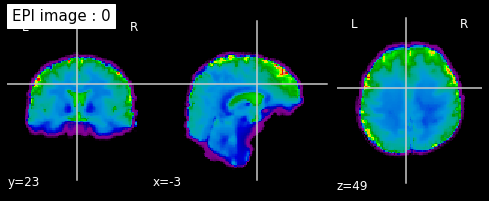

In [967]:
def get_img_in_time(img, time, TR=1.5):
    ### get relebvant img based on time mark

    return index_img(img,int(time/TR)), int(time/TR)
    
    
img = load_image(data_path_tmp)

sub_img, sub_img_n = get_img_in_time(img, 1.4)


plotting.plot_epi(sub_img,
            title='EPI image : {}'.format(sub_img_n))




In [1132]:
##find  high_variance_confounds

hvar_confound = image.high_variance_confounds(img, detrend=True)

#clean image
cl_img = image.clean_img(img, confounds = hvar_confound,
                         detrend=True, 
                standardize=True, high_pass=0.01, t_r=1.5)



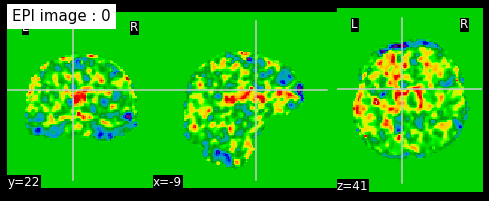

In [980]:
sub_cl_img, _ = get_img_in_time(cl_img, 1.4)

plotting.plot_epi(sub_cl_img,
            title='EPI image : {}'.format(sub_img_n))


In [981]:
########### utils
def load_image(path):
    # load an img file
    return nib.load(path)

def clean_image(img, detrend=True, standardize=True, TR=1.5, high_pass=0.01):
    
    #get high var confounds in time series
    hvar_confound = image.high_variance_confounds(img, 
                    detrend=detrend)

    #clean image
    cl_img = image.clean_img(img, confounds = hvar_confound,
                             detrend=detrend, 
                             standardize=standardize, 
                             high_pass=high_pass, 
                             t_r=TR)
    return cl_img

def get_TR(img):
    # retrieve TR data
    return img.header.get_zooms()[-1]

def get_slices(img):
    # retrieve number of slices
    return img.shape[2]
  
def get_header(img):
    # print the full header
    return(img.header)

## craete masker based on the atlas 
## and create a time series of the uploaded image using the masker
def create_mask(atlas_img, fmri_img):
  # generates a mask given img and atlas
  masker = input_data.NiftiLabelsMasker(labels_img=atlas_img, standardize=True)
  time_series = masker.fit_transform(fmri_img)
  
  return time_series

In [51]:
img = load_image(data_path_tmp)
header=get_header(img)
print(header['dim'])
#n dims ,x ,y ,z ,t

[  4  98  98  72 400   1   1   1]


In [52]:
TR = get_TR(img)
slices = get_slices(img)
print('TR: {}'.format(TR))
print('# of slices: {}'.format(slices))

TR: 1.5
# of slices: 72


In [328]:
# ## all data 
# TRs = []
# all_slices = []
# shapes = []
# for i in nifti_df.nifti:
#     TRs.append(get_TR(i))
#     all_slices.append(get_slices(i))
#     shapes.append(get_header(i)['dim'])

In [334]:
# print(set(all_slices))
# print(set(TRs))
# print(shapes[0])
# ## cool, all the same.

{72}
{1.5}
[  4  98  98  72 400   1   1   1]


In [ ]:
###### load atalses

'\nMSDL atlas - Result maps of sparse dictionary learning based on resting-state data.\nThis can be understand as a variant of ICA based on the assumption \nof sparsity rather than independence.\n\n'

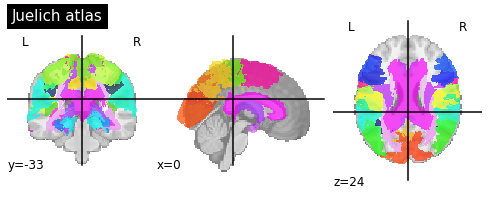

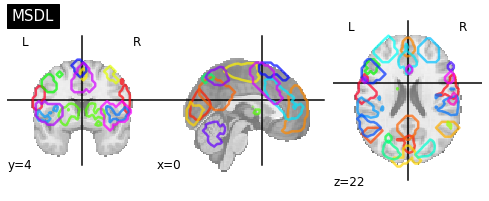

In [150]:
dataset_ju = datasets.fetch_atlas_juelich('maxprob-thr0-1mm')
atlas_ju_filename = dataset_ju.filename
atlas_ju_maps = dataset_ju.maps

plotting.plot_roi(atlas_ju_filename, title="Juelich atlas")

'''

A probabilistic atlas created by averaging multi-subject post-mortem cyto- 
and myelo-architectonic segmentations, performed by the team of Profs Zilles 
and Amunts at the Research Center Jülich and kindly provided by Simon Eickhoff.

The atlas contains 52 grey matter structures and 10 white matter structures. 

For the FSL version of this atlas, these probabilistic maps were then 
linearly transformed into MNI152 space

'''

dataset_msdl = datasets.fetch_atlas_msdl()
dataset_msdl_maps = dataset_msdl.maps
plotting.plot_prob_atlas(dataset_msdl_maps, title="MSDL")

'''
MSDL atlas - Result maps of sparse dictionary learning based on resting-state data.
This can be understand as a variant of ICA based on the assumption 
of sparsity rather than independence.

'''


In [ ]:
#spec ROIS

In [244]:
dataset_ju_rois = ['GM Hippocampus cornu ammonis',
 'GM Hippocampus dentate gyrus',
 'GM Hippocampus entorhinal cortex',
 'GM Hippocampus hippocampal-amygdaloid transition area',
 'GM Hippocampus subiculum']

dataset_ju_rois_id = [9,10,11,12,13]

dataset_msdl_rois = ['Striate', 'R DLPFC', 'L DLPFC']
dataset_msdl_rois_id = [2,9,15]


In [ ]:
# crate mask

In [214]:
ju_masker = input_data.NiftiLabelsMasker(labels_img= atlas_ju_maps, standardize=True)
msdl_masker = input_data.NiftiMapsMasker(maps_img= dataset_msdl['maps'], standardize=True)

msdl_time_series = msdl_masker.fit_transform(img)
ju_time_series = ju_masker.fit_transform(img)


In [257]:
ju_time_series_ROIs = ju_time_series[:,dataset_ju_rois_id]
ju_time_series_ROI_avg_hip = np.mean(ju_time_series[:,dataset_ju_rois_id],1).reshape(-1,1)

msdl_time_series_ROIs = msdl_time_series[:,dataset_msdl_rois_id]


In [ ]:
# create masked time series & merge

In [258]:
time_series_ROIS = np.concatenate([ju_time_series_ROIs,
                                   msdl_time_series_ROIs],-1)

time_series_ROIS_avg_hip = np.concatenate([ju_time_series_ROI_avg_hip,
                                   msdl_time_series_ROIs],-1)
time_series_ROIS.shape

(400, 8)

In [ ]:
print(ju_time_series.shape)
print(msdl_time_series.shape)
## 400 time steps, 62 ROIs
##62 labels len(dataset_ju.labels)

In [ ]:
#correlation things

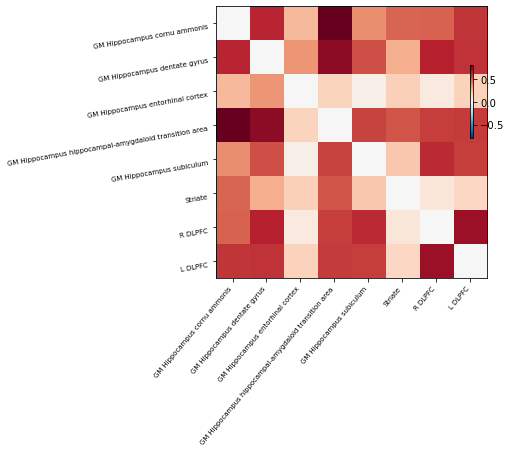

In [251]:

correlation_matrix = correlation_measure.fit_transform([time_series_ROIS])[0]

np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, labels=dataset_ju_rois+dataset_msdl_rois, 
                     
                     colorbar=True,
                     vmax=0.8, vmin=-0.8)

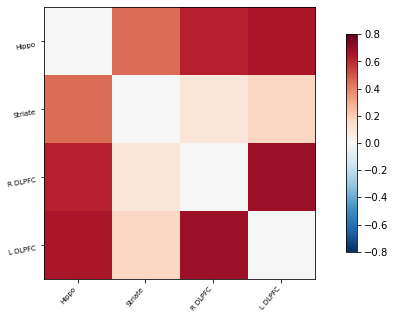

In [260]:

correlation_matrix = correlation_measure.fit_transform([time_series_ROIS_avg_hip])[0]

np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, labels=['Hippo']+dataset_msdl_rois, 
                     
                     colorbar=True,
                     vmax=0.8, vmin=-0.8)

In [372]:
nifti_df.run = nifti_df.run.astype(int)

In [982]:
n_sub=len(subject_ids)
n_runs=4

ju_masker = input_data.NiftiLabelsMasker(labels_img= atlas_ju_maps, standardize=True)
msdl_masker = input_data.NiftiMapsMasker(maps_img= dataset_msdl['maps'], standardize=True)



#data=np.zeros(n_sub, n_runs, n_slices, n_rois)
time_series_all = np.zeros((n_sub, n_runs, 400, 101))
                
for sub_i, sub in tqdm(enumerate(nifti_data)):
    for run in nifti_data[sub]:
        
        img_sub_run = load_image(nifti_data[sub][run])
        cl_img_sub_run = clean_image(img_sub_run)
        
        #print(img_sub_run)
    
        msdl_time_series = msdl_masker.fit_transform(cl_img_sub_run)
        ju_time_series = ju_masker.fit_transform(cl_img_sub_run) 
        
        ju_time_series = ju_time_series
        msdl_time_series = msdl_time_series
        
        time_series = np.concatenate([ju_time_series,
                                   msdl_time_series],-1)
       
        time_series_all[sub_i, run-1] = time_series
        
#         correlation_matrix = correlation_measure.fit_transform([time_series])[0]
#         correlation_matrixes_all[sub_i, run-1] = correlation_matrix
        
          

15it [1:56:27, 465.86s/it]


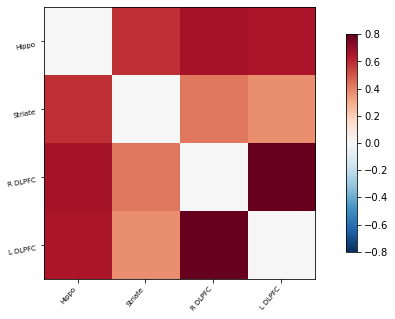

In [983]:
mean_cor1 = np.mean(np.mean(correlation_matrixes,axis=0),axis=0)

np.fill_diagonal(mean_cor1, 0)
plotting.plot_matrix(mean_cor1,
                     colorbar=True,
                     labels=['Hippo']+dataset_msdl_rois,
                     vmax=0.8, vmin=-0.8)



In [437]:
# np.save('correlation_matrixes_hipp_stra_RdlPFC_LdlPFC.npy',
#         correlation_matrixes)

In [457]:
# np.save('correlation_matrixes_all_ROIs.npy',
#         correlation_matrixes_all)


np.save('time_series_all.npy',
        time_series_all)


In [448]:
time_series_all.shape

(400, 101)

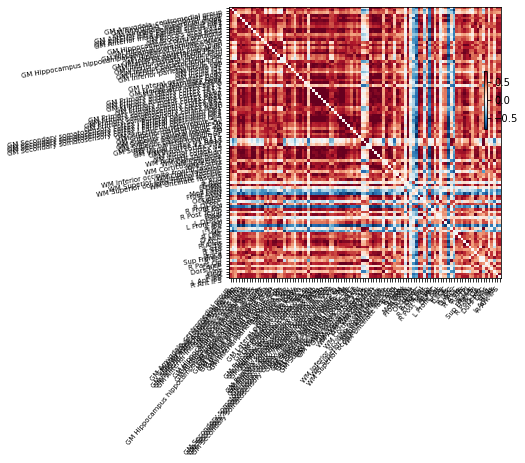

In [984]:
mean_cor2 = np.mean(np.mean(correlation_matrixes_all,axis=0),axis=0)

np.fill_diagonal(mean_cor2, 0)
plotting.plot_matrix(mean_cor2,
                     colorbar=True,
                     labels=dataset_ju.labels[1:]+dataset_msdl.labels,
                     vmax=0.8, vmin=-0.8)



0.3619519432793777
0.46453106509946807


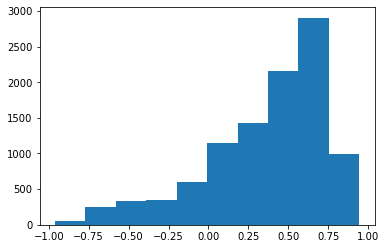

In [472]:
plt.hist(mean_cor.flat)
print(np.mean(mean_cor))
print(np.median(mean_cor))

plt.show()

In [ ]:
### bet GLM

In [1049]:
#all_behav_data[['button','onset']]

all_behav_data['bool_click'] = 0
all_behav_data.bool_click = all_behav_data.button.notna()
all_behav_data

,onset,duration,event_type,num_beads_high,num_beads_low,points_high,bead_type,bet_jar_type,button,initialVOI,updatedVOI,subject,run,bool_click
0,1.822896,3.065544,initial_beads,14.0,6.0,170,NaN,NaN,NaN,-1.81705,NaN,FT3594,1,False
1,4.958621,1.381369,extra_bead,NaN,NaN,170,high,NaN,NaN,-1.81705,-1.949980,FT3594,1,False
2,6.896906,0.000000,additional_draw_allowed,15.0,6.0,170,NaN,NaN,NaN,-1.81705,-1.949980,FT3594,1,False
3,8.002955,0.000000,terminate_draw,15.0,6.0,170,NaN,NaN,right,-1.81705,NaN,FT3594,1,True
4,8.455547,0.000000,bet,15.0,6.0,170,NaN,high,left,NaN,NaN,FT3594,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,592.977310,3.047147,initial_beads,14.0,6.0,70,NaN,NaN,NaN,-1.81705,NaN,IA3593,4,False
237,598.067641,1.159699,extra_bead,NaN,NaN,70,low,NaN,NaN,-1.81705,-1.664322,IA3593,4,False
238,600.279469,0.000000,additional_draw_allowed,14.0,7.0,70,NaN,NaN,NaN,-1.81705,-1.664322,IA3593,4,False
239,600.901776,0.000000,terminate_draw,14.0,7.0,70,NaN,NaN,right,-1.81705,NaN,IA3593,4,True


In [1050]:
## times and bet for all bets with high, high reward

glm_bet_high_df = all_behav_data[['subject','run','onset','bet_jar_type']][(all_behav_data['event_type']=='bet')&
               (all_behav_data['points_high']==170)]

glm_bet_all_df = all_behav_data[['subject','run','onset','bet_jar_type']][(all_behav_data['event_type']=='bet')]

### take slices of these time make a glm to decode the bet decision,

In [1111]:
#TR=1.5

######### get data
data_x_bet_high = np.zeros((n_sub, n_runs, 28, 101))
data_x_bet_high_6_t = np.zeros((n_sub, n_runs, 28, 6, 101))

data_y_bet_high = np.zeros((n_sub, n_runs, 28, 1))


for sub_i, sub in tqdm(enumerate(nifti_data)):
    for run in nifti_data[sub]:
        sub_run_times_high = glm_bet_high_df.onset[(glm_bet_high_df['subject']==subject) &
               (glm_bet_high_df['run']==run)].tolist()
        
        sub_run_bet_high = glm_bet_high_df.bet_jar_type[(glm_bet_high_df['subject']==subject) &
               (glm_bet_high_df['run']==run)].replace({'high':1,'low':-1}).tolist()
         
        
        for time_i, time in enumerate(sub_run_times_high):
            img_index = int(time/TR)-1

            data_x_bet_high[sub_i, run-1, time_i] = time_series_all[sub_i, run-1, img_index] 
            data_x_bet_high_6_t[sub_i, run-1, time_i] = time_series_all[sub_i, run-1, img_index-3:img_index+3]  
            
            data_y_bet_high[sub_i, run-1, time_i] = sub_run_bet_high[time_i]


#####            
data_x_bet_all_6_t = np.zeros((n_sub, n_runs, 59, 6, 101))
data_y_bet_all = np.zeros((n_sub, n_runs, 59, 1))


for sub_i, sub in tqdm(enumerate(nifti_data)):
    for run in nifti_data[sub]:
        sub_run_times_all = glm_bet_all_df.onset[(glm_bet_all_df['subject']==subject) &
               (glm_bet_all_df['run']==run)].tolist()
        
        sub_run_bet_all = glm_bet_all_df.bet_jar_type[(glm_bet_all_df['subject']==subject) &
               (glm_bet_all_df['run']==run)].replace({'high':1,'low':-1}).tolist()
            
          
        for time_i, time in enumerate(sub_run_times_all[:-1]):
            img_index = int(time/TR)-1
            
            data_x_bet_all_6_t[sub_i, run-1, time_i] = time_series_all[sub_i, run-1, img_index-3:img_index+3]              
            data_y_bet_all[sub_i, run-1, time_i] = sub_run_bet_all[time_i]
            
        

        
## sanity check button presses
data_x_motor_sanity_check = np.zeros((n_sub, n_runs, 241, 5, 2))
data_y_motor_sanity_check = np.zeros((n_sub, n_runs, 241, 1))


for sub_i, sub in tqdm(enumerate(nifti_data)):
    for run in nifti_data[sub]:
        sub_run_times_motor = all_behav_data.onset[(all_behav_data['subject']==subject) &
               (all_behav_data['run']==run)].tolist()

        sub_run_bet_motor = all_behav_data.bool_click[(all_behav_data['subject']==subject) &
               (all_behav_data['run']==run)].tolist()


        for time_i, time in enumerate(sub_run_times_motor[:-5]):
            img_index = int(time/TR)-1

            data_x_motor_sanity_check[sub_i, run-1, time_i] = time_series_all[sub_i, run-1, img_index:img_index+5, 31:33]
            data_y_motor_sanity_check[sub_i, run-1, time_i] = sub_run_bet_motor[time_i]

            
            

15it [00:00, 33.75it/s]
15it [00:00, 61.38it/s]
15it [00:00, 49.94it/s]


In [1112]:
data_y_bet_high_array = data_y_bet_high.reshape(1,-1)
data_x_bet_high_array = data_x_bet_high.reshape(101,-1)

data_x_bet_high_6_t_array = data_x_bet_high_6_t.reshape(101,6,-1)


data_y_bet_all_array = data_y_bet_all.reshape(1,-1)
data_x_bet_all_6_t_array = data_x_bet_all_6_t.reshape(101,6,-1)



data_y_motor_sanity_check_array = data_y_motor_sanity_check.reshape(1,-1)
data_x_motor_sanity_check_array = data_x_motor_sanity_check.reshape(5,2,-1)

In [987]:
# np.save('data_time_series_onset_time.npy',
#         data_x)

# np.save('data_bet.npy',
#         data_y)

In [1116]:
from sklearn import svm
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import Normalizer,MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline



In [989]:
svc = svm.SVC(kernel='linear') #.fit(data_x_array.T, data_y_array.reshape(-1))
log_reg = LogisticRegression()



In [1123]:


mm = make_pipeline(Normalizer())



In [1131]:
## motor button santiy check

for t in range(5):
    data_x_motor_sanity_check_array_norm = mm.fit_transform(data_x_motor_sanity_check_array[t].T)

    
    X_train, X_test, y_train, y_test = train_test_split(data_x_motor_sanity_check_array_norm, 
                                                        data_y_motor_sanity_check_array.reshape(-1), 
                                                    test_size=0.2, random_state=0)

    y_hat = svc.fit(X_train, y_train).decision_function(X_test)


    fpr, tpr, _ = roc_curve(y_test, y_hat)
    roc_auc = auc(fpr, tpr)



    
    print(roc_auc)
    
    
    

0.48307629653499506
0.48307629653499506
0.48307629653499506
0.48307629653499506
0.48307629653499506


In [ ]:
scores = cross_validate(svc, data_x_bet_high_array.T, 
                        data_y_bet_high_array.reshape(-1),
                        scoring=['roc_auc'],
           cv=3, return_train_score=True)




In [991]:
scores

{'fit_time': array([0.16367793, 0.13086915, 0.14574218]),
 'score_time': array([0.03176713, 0.01798606, 0.02170396]),
 'test_roc_auc': array([0.45757576, 0.37060606, 0.54352273]),
 'train_roc_auc': array([0.50291667, 0.62328125, 0.50291667])}

In [992]:
svc = svm.SVC(kernel='linear').fit(data_x_array.T, data_y_array.reshape(-1))


In [993]:
svc.coef_
#svc.intercept_
top_20_feat_idx = np.argsort(np.abs(svc.coef_))[0][-20:]
all_lables = [dataset_ju.labels + dataset_msdl.labels][0][1:]

top_20_feat_labels = [all_lables[i] for i in top_20_feat_idx]

In [994]:
##only top 20 (double dipping?)

In [995]:
top_20_feat_labels

['L Par',
 'GM Visual cortex V2 BA18',
 'GM Inferior parietal lobule PF',
 'L DLPFC',
 'GM Primary somatosensory cortex BA1',
 'GM Inferior parietal lobule PFop',
 'L Ins',
 'GM Anterior intra-parietal sulcus hIP1',
 'D ACC',
 'GM Inferior parietal lobule PGp',
 'GM Amygdala_centromedial group',
 'L IPS',
 'GM Superior parietal lobule 5M',
 'WM Inferior occipito-frontal fascicle',
 'GM Inferior parietal lobule PFt',
 'GM Superior parietal lobule 7M',
 'GM Anterior intra-parietal sulcus hIP3',
 'L Aud',
 'GM Primary motor cortex BA4a',
 'GM Primary auditory cortex TE1.0']

In [996]:
X_train, X_test, y_train, y_test = train_test_split(data_x_bet_high_array[top_20_feat_idx].T, data_y_array.reshape(-1), 
                                                    test_size=0.5, random_state=0)

y_hat = svc.fit(X_train, y_train).decision_function(X_test)


fpr, tpr, _ = roc_curve(y_test, y_hat)
roc_auc = auc(fpr, tpr)


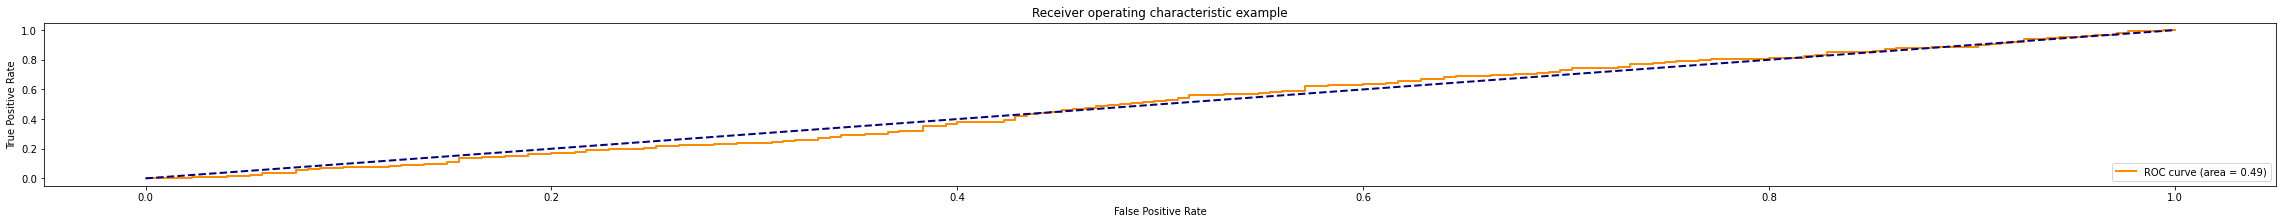

In [997]:
plt.figure()
lw = 2
plt.plot(
    fpr, tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [998]:
cv = StratifiedKFold(n_splits=6)



def auc_kfold(X = data_x_bet_high_array.T, y = data_y_array.reshape(-1),
             classifier =svc ,cv=cv):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X[test],
            y[test],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic example",
    )
    ax.legend(loc="lower right")
    plt.show()


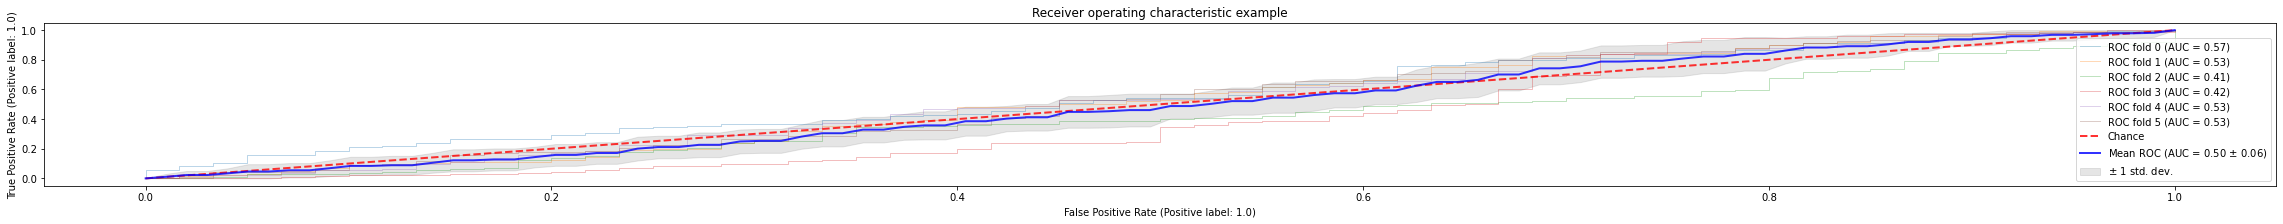

In [999]:
auc_kfold()

In [834]:
all_scores_test = []
all_scores_train = []

for i in range(101):
    
    scores_0 = cross_validate(log_reg, data_x_bet_high_array[i].reshape(-1,1), 
                            data_y_bet_high_array.reshape(-1),
                            scoring=['roc_auc'],
               cv=3, return_train_score=True)
    
    all_scores_test.append(scores_0['test_roc_auc'].mean())
    all_scores_train.append(scores_0['train_roc_auc'].mean())
    
    
    

(array([ 2.,  8.,  9., 24., 19.,  9.,  6.,  3., 15.,  6.]),
 array([0.47224747, 0.47623611, 0.48022475, 0.48421338, 0.48820202,
        0.49219066, 0.49617929, 0.50016793, 0.50415657, 0.5081452 ,
        0.51213384]),
 <BarContainer object of 10 artists>)

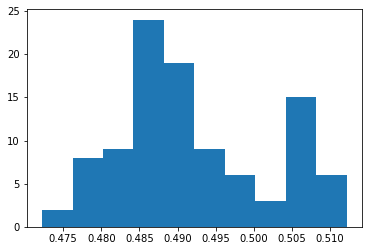

In [801]:
plt.hist(all_scores_test)

(array([ 2.,  6.,  5., 12., 18., 21.,  7., 17.,  7.,  6.]),
 array([0.49895202, 0.50035385, 0.50175568, 0.50315751, 0.50455934,
        0.50596117, 0.50736301, 0.50876484, 0.51016667, 0.5115685 ,
        0.51297033]),
 <BarContainer object of 10 artists>)

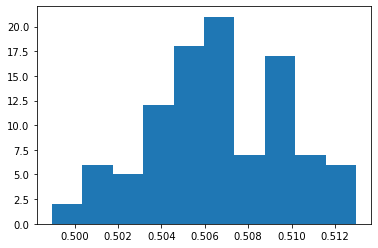

In [802]:
plt.hist(all_scores_train)

In [833]:
all_scores_test_6t = []
all_scores_train_6t = []

for i in range(101):
    
    scores_0 = cross_validate(log_reg, data_x_bet_high_6_t_array[i].reshape(-1,6), 
                            data_y_bet_high_array.reshape(-1),
                            scoring=['roc_auc'],
               cv=3, return_train_score=True)
    
    all_scores_test_6t.append(scores_0['test_roc_auc'].mean())
    all_scores_train_6t.append(scores_0['train_roc_auc'].mean())
    
    
    

(array([ 6.,  1.,  4.,  6.,  8., 18., 16., 11., 15., 16.]),
 array([0.53758049, 0.54098027, 0.54438005, 0.54777983, 0.55117961,
        0.55457939, 0.55797917, 0.56137895, 0.56477872, 0.5681785 ,
        0.57157828]),
 <BarContainer object of 10 artists>)

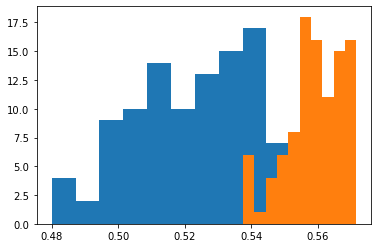

In [836]:

plt.hist(all_scores_test_6t)
plt.hist(all_scores_train_6t)

In [877]:
np.sum(data_y_bet_high_array==-1)

#1320, 360


0.2727272727272727

In [862]:
all_scores_test_6t_all = []
all_scores_train_6t_all = []

for i in range(101):
    
    scores_0 = cross_validate(log_reg, data_x_bet_all_6_t_array[i].reshape(-1,6), 
                            data_y_bet_all_array.reshape(-1),
                            scoring=['roc_auc'],
               cv=3, return_train_score=True)
    
    all_scores_test_6t_all.append(scores_0['test_roc_auc'].mean())
    all_scores_train_6t_all.append(scores_0['train_roc_auc'].mean())
        

In [873]:
set(all_behav_data.event_type)

{'additional_draw',
 'additional_draw_allowed',
 'bet',
 'extra_bead',
 'initial_beads',
 'terminate_draw'}

In [908]:
#additional_draw_allowed

#additional_draw,  #terminate_draw



In [912]:
all_behav_data

,onset,duration,event_type,num_beads_high,num_beads_low,points_high,bead_type,bet_jar_type,button,initialVOI,updatedVOI,subject,run,trial
0,1.822896,3.065544,initial_beads,14.0,6.0,170,NaN,NaN,NaN,-1.81705,NaN,FT3594,1,0
1,4.958621,1.381369,extra_bead,NaN,NaN,170,high,NaN,NaN,-1.81705,-1.949980,FT3594,1,0
2,6.896906,0.000000,additional_draw_allowed,15.0,6.0,170,NaN,NaN,NaN,-1.81705,-1.949980,FT3594,1,0
3,8.002955,0.000000,terminate_draw,15.0,6.0,170,NaN,NaN,right,-1.81705,NaN,FT3594,1,0
4,8.455547,0.000000,bet,15.0,6.0,170,NaN,high,left,NaN,NaN,FT3594,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,592.977310,3.047147,initial_beads,14.0,6.0,70,NaN,NaN,NaN,-1.81705,NaN,IA3593,4,0
237,598.067641,1.159699,extra_bead,NaN,NaN,70,low,NaN,NaN,-1.81705,-1.664322,IA3593,4,0
238,600.279469,0.000000,additional_draw_allowed,14.0,7.0,70,NaN,NaN,NaN,-1.81705,-1.664322,IA3593,4,0
239,600.901776,0.000000,terminate_draw,14.0,7.0,70,NaN,NaN,right,-1.81705,NaN,IA3593,4,0


In [948]:
t = 0
#curr_sub = np.nan
curr_run = np.nan
trials = []
for index, row in all_behav_data.iterrows():

    r_sub = row['subject']
    r_run = row['run']
    r_event = row['event_type']
    
    # start counting again in new run
    if r_run != curr_run:
        t=0
        curr_run = r_run
    
    # if event is onset, new trial
    if r_event == 'initial_beads':
        t+=1
    
    
    trials.append(t)
   
    

In [950]:
all_behav_data['trial'] = trials

In [961]:
['additional_draw_allowed' in i for i in all_behav_data.groupby(['subject','run','trial'])['event_type'].apply(list).tolist()]



[True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True